In [349]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [389]:
mn = pd.read_csv('../data/BORO_zip_files_csv/MN.csv')
qn = pd.read_csv('../data/BORO_zip_files_csv/QN.csv')
bk = pd.read_csv('../data/BORO_zip_files_csv/BK.csv')
si = pd.read_csv('../data/BORO_zip_files_csv/SI.csv')
bx = pd.read_csv('../data/BORO_zip_files_csv/BX.csv')
bdf = pd.concat([mn,qn,bk,si,bx])
cdf = pd.read_csv('../data/311_sample_head.csv')

In [219]:
bdf.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,MN,1,10,101,5.0,1018.0,2.0,1.0,10004.0,E007,...,190225.0,16a,Y,199 999,10101.0,NaN,0.0,NaN,1,16V2
1,MN,1,101,101,1.0,1001.0,2.0,1.0,10004.0,E007,...,190636.0,16a,Y,199 999,10101.0,NaN,0.0,NaN,1,16V2
2,MN,1,201,101,1.0,1000.0,2.0,1.0,10004.0,E007,...,193648.0,12b,NaN,199 999,10101.0,NaN,0.0,NaN,1,16V2
3,MN,1,301,101,NaN,NaN,2.0,1.0,10004.0,E007,...,NaN,12b,NaN,199 999,10101.0,NaN,0.0,NaN,4,16V2
4,MN,1,401,101,NaN,NaN,2.0,1.0,10004.0,E007,...,NaN,12b,NaN,1 99 999,10101.0,NaN,0.0,NaN,4,16V2


In [394]:
def clean_address(address):
    try:
        return str.upper(address).strip()
    except:
        return None

In [395]:
def clean(df):
    df = df[['Address','XCoord','YCoord','ZipCode','YearBuilt','Borough']].copy()
    df['Address'] = df['Address'].apply(clean_address)
    df.drop(df[df['YearBuilt']==0].index,inplace=True)
    return df

In [396]:
def summary(df):
    pct_null = df['Address'].isnull().sum()*1./df.shape[0]
    print "pct null:",round(pct_null,2)
    print df['Address'].value_counts().head(10)

# Neighborhoods

In [397]:
def import_neighborhoods(fname):
    '''
    import wikipedia neighborhoods file
    returns: dictionary where key is borough
        and value is list of neighborhoods
    '''
    with open(fname,'r') as f:
        raw = f.read()
    lines = raw.split('\n')
    boroughs = {}
    for line in lines:
        fields = line.split(',')
        borough = fields.pop(0)
        if borough not in boroughs:
            boroughs[borough]=[]
        for f in fields:
            if f:
                neighborhood = str.upper(f.strip())
                boroughs[borough].append(neighborhood)
    boroughs2 = {'QN':boroughs['Queens']+['QUEENS'],
                 'BK':boroughs['Brooklyn']+['BROOKLYN'],
                 'MN':boroughs['Manhattan']+['MANHATTAN','NEW YORK'],
                 'SI':boroughs['Staten Island']+['STATEN ISLAND'],
                 'BX':boroughs['Bronx']+['BRONX']}
    return boroughs2

In [398]:
def city2borough(city):
    for borough,hood_list in neighborhoods.iteritems():
        if city in hood_list:
            return borough

# Apply functions

In [406]:
#clean data
bdf = clean(bdf)

#clean up and rename address
cdf['Address'] = cdf['Incident Address'].apply(clean_address)

#import neighborhoods data
hoods_fname='../data/wiki_neighborhoods_2.csv'
neighborhoods = import_neighborhoods(hoods_fname)
cdf['borough2'] = cdf['Borough'].copy()
cdf['Borough'] = cdf.City.apply(city2borough)
hdf = cdf[cdf['Complaint Type']=='HEATING']

## Many boroughs that were previously unspecified now are specified

In [362]:
pd.crosstab(cdf.Borough,cdf.borough2)

borough2,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND,Unspecified
Borough,,,,,,
BK,0,15032,0,6,0,14885
BX,6038,1,1,1,0,14628
MN,1,6,9741,2,0,8814
QN,1,3,1,14381,0,4877
SI,0,0,0,135,3876,665


In [417]:
#Remove duplicates from buildings dataframe.  Only keep the newest one
bdf = bdf.sort_values(by='YearBuilt',ascending=False)
dupes = bdf.duplicated(subset=['Borough','Address'],keep='first')
bdf.drop(dupes[dupes].index,inplace=True)

In [419]:
#Merge buildings dataframe with heating dataframe
mdf = hdf.merge(bdf,how='inner',on=['Address','Borough'])

In [420]:
print mdf.shape
print hdf.shape
print bdf.shape

(15856, 58)
(21655, 54)
(715058, 6)


In [421]:
counts = mdf.groupby(['YearBuilt']).count()

In [438]:
mdf.shape[0]*1./hdf.shape[0]-1

-0.26779034864927265

## More complaints from older buildings.  But are there just more older buildings?

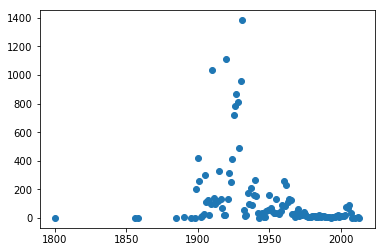

In [434]:
plt.scatter(counts.index,counts['Complaint Type'])

## Number of buildings by age

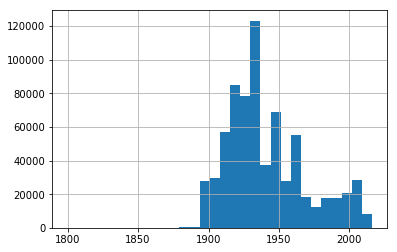

In [461]:
bdf.loc[bdf['YearBuilt']>=1800,'YearBuilt'].hist(bins=30)

In [453]:
building_counts = bdf.groupby('YearBuilt').count()['Borough']

In [457]:
counts['building_count']=building_counts

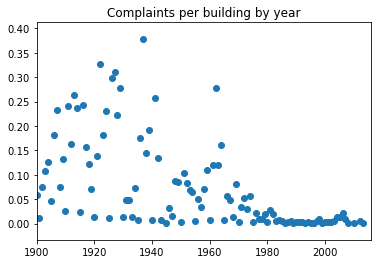

In [462]:
plt.scatter(counts.index,counts['Complaint Type']/counts['building_count'])
plt.xlim([1900,2016])
plt.title("Complaints per building by year")